In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Thu Jun 23 23:47:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 40%   52C    P2    80W / 260W |   4535MiB / 11019MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 25%   

# LDA

## 2016 brief paragraph

In [3]:
file_cn = open("../LDA/segment/data/cn_file_brief_paragraph_2016.txt", "r")
cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(cn_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(12307 unique tokens: ['上游', '下游', '产生', '例中', '信号']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in cn_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 3), (1, 4), (2, 1), (3, 1), (4, 5), (5, 1), (6, 1), (7, 1), (8, 6), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-7.191062,1327.511863
1,3,-7.152236,1276.958171
2,4,-7.156650,1282.607595
3,5,-7.145410,1268.270670
4,6,-7.139720,1261.075762
5,7,-7.105342,1218.458216
6,8,-7.086474,1195.684836
7,9,-7.097076,1208.428253
8,10,-7.090514,1200.524549
9,11,-7.090816,1200.887849


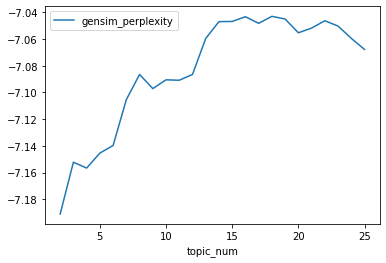

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-7.191062,1327.511863
1,3,-7.152236,1276.958171
2,4,-7.156650,1282.607595
3,5,-7.145410,1268.270670
4,6,-7.139720,1261.075762
5,7,-7.105342,1218.458216
6,8,-7.086474,1195.684836
7,9,-7.097076,1208.428253
8,10,-7.090514,1200.524549
9,11,-7.090816,1200.887849


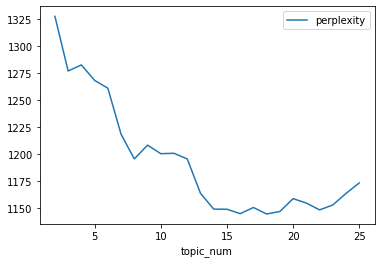

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_cn_brief_paragraph_2016.csv", index=False)

## priority description sentence

In [11]:
# file_cn = open("../MUSE-main/data/cn_file_desc_p_s_2500.txt", "r")
# cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(cn_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in cn_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_cn_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

2

In [23]:
topics_cn = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_cn.append(c.index(max(c)))

In [24]:
topics_cn

[2,
 14,
 3,
 12,
 13,
 7,
 13,
 13,
 12,
 6,
 14,
 12,
 8,
 17,
 17,
 17,
 13,
 6,
 12,
 4,
 10,
 8,
 15,
 10,
 17,
 12,
 6,
 3,
 6,
 6,
 15,
 14,
 16,
 16,
 6,
 14,
 16,
 12,
 12,
 10,
 6,
 12,
 14,
 12,
 7,
 2,
 17,
 8,
 8,
 15,
 14,
 8,
 6,
 16,
 17,
 12,
 6,
 11,
 12,
 8,
 5,
 8,
 6,
 16,
 12,
 8,
 15,
 6,
 4,
 4,
 6,
 8,
 16,
 8,
 14,
 12,
 12,
 6,
 1,
 8,
 12,
 0,
 8,
 6,
 14,
 5,
 9,
 14,
 13,
 6,
 8,
 16,
 17,
 9,
 8,
 15,
 12,
 4,
 14,
 12,
 8,
 14,
 13,
 16,
 7,
 12,
 9,
 10,
 8,
 13,
 17,
 13,
 6,
 13,
 13,
 6,
 11,
 13,
 13,
 8,
 17,
 12,
 11,
 3,
 6,
 12,
 4,
 8,
 1,
 17,
 11,
 17,
 8,
 16,
 1,
 13,
 8,
 4,
 8,
 16,
 12,
 15,
 3,
 5,
 6,
 2,
 5,
 12,
 6,
 7,
 12,
 14,
 8,
 12,
 8,
 13,
 15,
 4,
 15,
 14,
 13,
 13,
 4,
 14,
 3,
 15,
 2,
 10,
 11,
 7,
 1,
 7,
 14,
 7,
 7,
 13,
 7,
 7,
 7,
 15,
 7,
 8,
 13,
 6,
 14,
 12,
 7,
 15,
 5,
 1,
 8,
 16,
 13,
 14,
 13,
 8,
 7,
 10,
 7,
 8,
 13,
 6,
 1,
 6,
 15,
 1,
 8,
 7,
 8,
 14,
 8,
 13,
 13,
 9,
 12,
 13,
 1,
 16,
 14,
 12,
 7,


In [25]:
print(len(topics_cn))
print(len(cn_desc))

2884
2884


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_cn = db.rm_patent_cn
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2016 = db.rm_patent_us_2016
    db_rm_cn_2016 = db.rm_patent_cn_2016
    # db_rm_de_2016 = db.rm_patent_de_2016
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_cn_desc = p_db_cn.find({}, {"patentNumber":1, "brief": 1})
data_cn_desc = db_rm_cn_2016.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_cn_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_cn

,id,patentNumber,company,brief
0,61fda0e1f4d57576a5022cdd,CN106878125A,[Analog Devices Inc],本文所公开的是双线通信系统及其应用。在一些实施例中，低延迟通信的从节点收发器可以包括上游收发...
1,61fda235f4d57576a5022e81,CN108369765B,[Saphibeat Technologies Inc],呈现用于一种或多种可穿戴电子装置的各种实施例，所述可穿戴电子装置可安装在例如头盔、服装、护具...
2,61fda2faf4d57576a5022e9b,CN106228175A,[International Business Machines Corp],本发明一般地涉及自非常高速率的数据流的水平决策树学习。这里提供了在数据处理系统中用于分布式树...
3,61fda534f4d57576a5022eb9,CN107209273A,[Samsung Electronics Co Ltd],提供了一种电子设备和电子设备的方法。所述电子设备包括：位置测量模块，被配置为测量位置；存储器...
4,61fda66ef4d57576a5022ed5,CN106854367A,[Shin Etsu Chemical Co Ltd],None
...,...,...,...,...
2879,61ffe0eaf4d57576a502c45b,CN105695541A,"[SUZHOU ENZYMEWORKS Inc, Biosynthetica Inc]",本发明公开了一种抗生素NVP018中间体的分离纯化方法，通过在链霉菌接种至发酵培养基中进行发...
2880,61ffe0ebf4d57576a502c45d,CN107120091A,[Shelfoil Petroleum Equipment And Services Co ...,本发明涉及一种回接装置，其包括：回接本体，设置于回接本体上游处的提拉管，提拉管一端与送入钻具...
2881,61ffe0edf4d57576a502c45f,CN107120090A,"[SHELFOIL PETROLEUM EQUIPMENT & SERVICES Co.,L...",本发明涉及回接装置及尾管补救固井方法。回接装置包括：回接本体，设置于回接本体上游处的提拉管，...
2882,61ffe0edf4d57576a502c461,CN105535081A,[],本发明公开了一种治疗中风偏瘫的药物组合物，包括注射剂、口服西药和口服中药。本发明的治疗中风偏...


In [30]:
print(len(df_cn))
print(len(cn_desc))

2884
2884


In [31]:
df_cn["topic"]=topics_cn

In [32]:
df_cn

,id,patentNumber,company,brief,topic
0,61fda0e1f4d57576a5022cdd,CN106878125A,[Analog Devices Inc],本文所公开的是双线通信系统及其应用。在一些实施例中，低延迟通信的从节点收发器可以包括上游收发...,2
1,61fda235f4d57576a5022e81,CN108369765B,[Saphibeat Technologies Inc],呈现用于一种或多种可穿戴电子装置的各种实施例，所述可穿戴电子装置可安装在例如头盔、服装、护具...,14
2,61fda2faf4d57576a5022e9b,CN106228175A,[International Business Machines Corp],本发明一般地涉及自非常高速率的数据流的水平决策树学习。这里提供了在数据处理系统中用于分布式树...,3
3,61fda534f4d57576a5022eb9,CN107209273A,[Samsung Electronics Co Ltd],提供了一种电子设备和电子设备的方法。所述电子设备包括：位置测量模块，被配置为测量位置；存储器...,12
4,61fda66ef4d57576a5022ed5,CN106854367A,[Shin Etsu Chemical Co Ltd],None,13
...,...,...,...,...,...
2879,61ffe0eaf4d57576a502c45b,CN105695541A,"[SUZHOU ENZYMEWORKS Inc, Biosynthetica Inc]",本发明公开了一种抗生素NVP018中间体的分离纯化方法，通过在链霉菌接种至发酵培养基中进行发...,17
2880,61ffe0ebf4d57576a502c45d,CN107120091A,[Shelfoil Petroleum Equipment And Services Co ...,本发明涉及一种回接装置，其包括：回接本体，设置于回接本体上游处的提拉管，提拉管一端与送入钻具...,9
2881,61ffe0edf4d57576a502c45f,CN107120090A,"[SHELFOIL PETROLEUM EQUIPMENT & SERVICES Co.,L...",本发明涉及回接装置及尾管补救固井方法。回接装置包括：回接本体，设置于回接本体上游处的提拉管，...,9
2882,61ffe0edf4d57576a502c461,CN105535081A,[],本发明公开了一种治疗中风偏瘫的药物组合物，包括注射剂、口服西药和口服中药。本发明的治疗中风偏...,5


In [33]:
df_cn2 = df_cn.explode('company')
df_cn2

,id,patentNumber,company,brief,topic
0,61fda0e1f4d57576a5022cdd,CN106878125A,Analog Devices Inc,本文所公开的是双线通信系统及其应用。在一些实施例中，低延迟通信的从节点收发器可以包括上游收发...,2
1,61fda235f4d57576a5022e81,CN108369765B,Saphibeat Technologies Inc,呈现用于一种或多种可穿戴电子装置的各种实施例，所述可穿戴电子装置可安装在例如头盔、服装、护具...,14
2,61fda2faf4d57576a5022e9b,CN106228175A,International Business Machines Corp,本发明一般地涉及自非常高速率的数据流的水平决策树学习。这里提供了在数据处理系统中用于分布式树...,3
3,61fda534f4d57576a5022eb9,CN107209273A,Samsung Electronics Co Ltd,提供了一种电子设备和电子设备的方法。所述电子设备包括：位置测量模块，被配置为测量位置；存储器...,12
4,61fda66ef4d57576a5022ed5,CN106854367A,Shin Etsu Chemical Co Ltd,None,13
...,...,...,...,...,...
2881,61ffe0edf4d57576a502c45f,CN107120090A,"SHELFOIL PETROLEUM EQUIPMENT & SERVICES Co.,Ltd.",本发明涉及回接装置及尾管补救固井方法。回接装置包括：回接本体，设置于回接本体上游处的提拉管，...,9
2881,61ffe0edf4d57576a502c45f,CN107120090A,China Petroleum and Chemical Corp,本发明涉及回接装置及尾管补救固井方法。回接装置包括：回接本体，设置于回接本体上游处的提拉管，...,9
2881,61ffe0edf4d57576a502c45f,CN107120090A,Sinopec Research Institute of Petroleum Engine...,本发明涉及回接装置及尾管补救固井方法。回接装置包括：回接本体，设置于回接本体上游处的提拉管，...,9
2882,61ffe0edf4d57576a502c461,CN105535081A,NaN,本发明公开了一种治疗中风偏瘫的药物组合物，包括注射剂、口服西药和口服中药。本发明的治疗中风偏...,5


In [34]:
# 排名前16的公司
c_ls = list(df_cn2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['ZTE Corp',
 'Huawei Technologies Co Ltd',
 'Anhui Sharetronic Iot Technology Co Ltd',
 'Xian Irain IoT Technology Service Co Ltd',
 'Shanghai Langbo Communication Technology Co Ltd',
 'Nanjing IoT Sensor Technology Co Ltd',
 'SUZHOU XUANHE IOT TECHNOLOGY Co Ltd',
 'Jiangsu IoT Research and Development Center',
 'China Mobile Communications Group Co Ltd',
 'Shenzhen JBT Smart Lighting Co Ltd',
 'Samsung Electronics Co Ltd',
 'Shenzhen Mayixiongbing Iot Technology Co Ltd',
 'Chengdu Qinchuan IoT Technology Co Ltd',
 'SHENZHEN QIANHAI LINGJU INTERNET OF THINGS SCIENCE & TECHNOLOGY Co Ltd',
 'Shenzhen Qianhai Livall IoT Technology Co Ltd',
 'Datang Mobile Communications Equipment Co Ltd']

### 轉成company-topic 的總數表格

In [35]:
df_cn_count = df_cn2.groupby(["company","topic"],as_index=False).size()
df_cn_count

,company,topic,size
0,"A IOT Technology Co., Ltd. (the)",5,2
1,"A IOT Technology Co., Ltd. (the)",8,1
2,AGC Inc,1,1
3,"ANHUI ELINK SMART Co.,Ltd.",1,1
4,ANHUI SAIAN SAFE EQUIPMENT Co Ltd,1,1
...,...,...,...
1727,Zhuzhou Qianjin Pharmaceutical Co Ltd,6,1
1728,Zhuzhou Qianjin Pharmaceutical Co Ltd,16,1
1729,Zhuzhou Times New Material Technology Co Ltd,8,1
1730,Zhuzhou Times New Material Technology Co Ltd,14,1


In [36]:
# 轉成company-topic 的總數表格
table_cn = df_cn_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_cn = table_cn.droplevel(level=0, axis=1)
table_cn = table_cn.rename(columns={'':'company'})

In [37]:
table_cn

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,"A IOT Technology Co., Ltd. (the)",0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AGC Inc,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"ANHUI ELINK SMART Co.,Ltd.",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ANHUI SAIAN SAFE EQUIPMENT Co Ltd,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ARM Ltd,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,Zhuhai Unicook Technology Co Ltd,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0
962,Zhuhai Youte IoT Technology Co Ltd,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
963,Zhuzhou Qianjin Pharmaceutical Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
964,Zhuzhou Times New Material Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [38]:
final_table_cn = table_cn[table_cn.company.isin(c_ls)]
final_table_cn

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
19,Anhui Sharetronic Iot Technology Co Ltd,1.0,20.0,1.0,0.0,1.0,4.0,3.0,13.0,4.0,7.0,1.0,7.0,0.0,4.0,1.0,14.0,2.0,2.0
116,Chengdu Qinchuan IoT Technology Co Ltd,0.0,6.0,1.0,5.0,1.0,1.0,0.0,5.0,0.0,2.0,2.0,1.0,0.0,2.0,6.0,3.0,0.0,1.0
135,China Mobile Communications Group Co Ltd,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,13.0,1.0,2.0,0.0,16.0,1.0
183,Datang Mobile Communications Equipment Co Ltd,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,11.0,1.0,0.0,0.0,15.0,1.0
360,Huawei Technologies Co Ltd,0.0,0.0,1.0,0.0,0.0,0.0,8.0,1.0,11.0,0.0,0.0,0.0,46.0,2.0,2.0,1.0,37.0,2.0
415,Jiangsu IoT Research and Development Center,2.0,1.0,4.0,2.0,0.0,1.0,3.0,3.0,12.0,3.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,4.0
496,Nanjing IoT Sensor Technology Co Ltd,2.0,5.0,0.0,2.0,0.0,5.0,0.0,4.0,15.0,6.0,6.0,2.0,0.0,2.0,0.0,5.0,0.0,0.0
590,SHENZHEN QIANHAI LINGJU INTERNET OF THINGS SCI...,2.0,4.0,0.0,3.0,4.0,0.0,0.0,0.0,9.0,2.0,2.0,2.0,0.0,3.0,0.0,1.0,0.0,2.0
603,SUZHOU XUANHE IOT TECHNOLOGY Co Ltd,0.0,1.0,0.0,0.0,7.0,2.0,1.0,12.0,1.0,0.0,0.0,3.0,0.0,3.0,9.0,5.0,0.0,9.0
606,Samsung Electronics Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,3.0,1.0,1.0,1.0,12.0,0.0,2.0,1.0,7.0,1.0


In [39]:
final_table_cn.shape

(16, 19)

In [40]:
table_cn.to_csv('company_lda_brief_cn_2016.csv',index=0)